In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
%matplotlib inline

np.random.seed(2)

from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


In [2]:
#!python3 -m pip install --force-reinstall scikit-learn==0.20.3
#!python3 -m pip install keras

In [2]:
# Load the data
DATA_PATH = os.path.join('datasets','emnist')
def get_data(filename,path=DATA_PATH):
    file_path = path+filename
    df = pd.read_csv(file_path,header=None)
    data = df.iloc[:,1:]
    target = df.iloc[:,0]
    del df # Free up Memory
    return target,data

print("Loading Traning Data ...")
Y_train,X_train = get_data('/emnist-bymerge-train.csv')
#Y_test,X_test = get_data('/emnist-bymerge-test.csv')
X_train.info()

Loading Traning Data ...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697932 entries, 0 to 697931
Columns: 784 entries, 1 to 784
dtypes: int64(784)
memory usage: 4.1 GB


In [3]:
# The merged classes, as suggested by the NIST, are for the letters C, I, J, K, L, M, O, P, S, U,V, W, X, Y and Z
# int to char Mapping for Merged Data set
def getlabeldict(file,path = DATA_PATH):
    lbl_dict = {}
    with open(path+file) as f:
        for line in f.readlines():
            line = line.split(' ')
            lbl_dict[int(line[0])] = str(chr(int(line[1])))
    return lbl_dict
lbl_dict = getlabeldict('/emnist-bymerge-mapping.txt')
print(lbl_dict.items())
def charLabel(x,Lbl_dict):
    return Lbl_dict[x]  

dict_items([(0, '0'), (1, '1'), (2, '2'), (3, '3'), (4, '4'), (5, '5'), (6, '6'), (7, '7'), (8, '8'), (9, '9'), (10, 'A'), (11, 'B'), (12, 'C'), (13, 'D'), (14, 'E'), (15, 'F'), (16, 'G'), (17, 'H'), (18, 'I'), (19, 'J'), (20, 'K'), (21, 'L'), (22, 'M'), (23, 'N'), (24, 'O'), (25, 'P'), (26, 'Q'), (27, 'R'), (28, 'S'), (29, 'T'), (30, 'U'), (31, 'V'), (32, 'W'), (33, 'X'), (34, 'Y'), (35, 'Z'), (36, 'a'), (37, 'b'), (38, 'd'), (39, 'e'), (40, 'f'), (41, 'g'), (42, 'h'), (43, 'n'), (44, 'q'), (45, 'r'), (46, 't')])


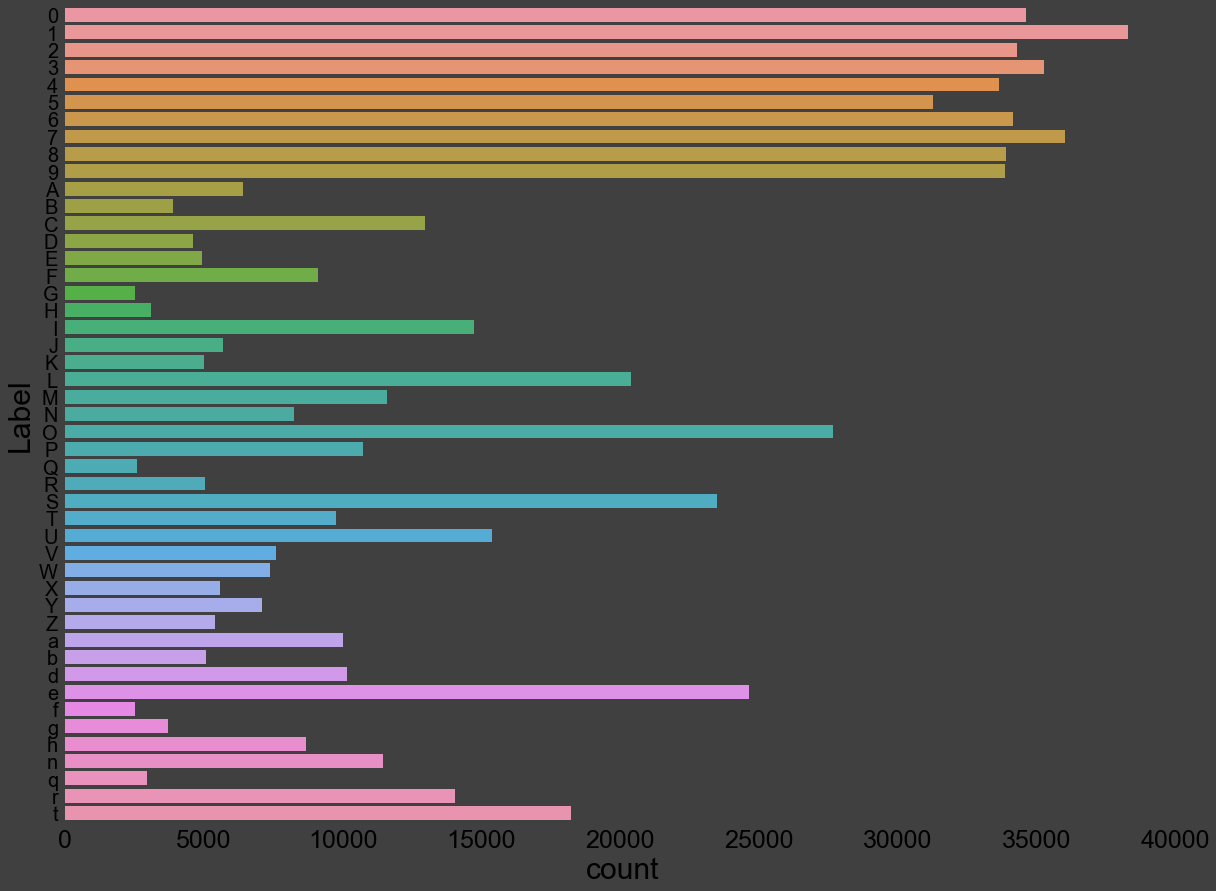

In [4]:
Y_train.name = "Label"
cY_train = Y_train.apply(charLabel,convert_dtype=False,args=(lbl_dict,)).sort_values()

bg_color = (0.25, 0.25, 0.25)
sns.set(rc={"font.style":"normal",
            "axes.facecolor":bg_color,
            "figure.facecolor":bg_color,
            "text.color":"black",
            "xtick.color":"black",
            "ytick.color":"black",
            "axes.labelcolor":"black",
            "axes.grid":False,
            'axes.labelsize':30,
            'figure.figsize':(20.0, 15.0),
            'xtick.labelsize':25,
            'ytick.labelsize':20})
g = sns.countplot(y = cY_train)


In [56]:
# check the data for missing values
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [59]:
#X_train.info() # Rows, Columns
X_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697932 entries, 0 to 697931
Columns: 784 entries, 1 to 784
dtypes: int64(784)
memory usage: 4.1 GB


,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
count,697932.0,697932.0,697932.0,697932.000000,697932.000000,697932.000000,697932.000000,697932.000000,697932.000000,697932.000000,...,697932.000000,697932.000000,697932.000000,697932.000000,697932.000000,697932.0,697932.0,697932.0,697932.0,697932.0
mean,0.0,0.0,0.0,0.000009,0.000853,0.004304,0.007174,0.007410,0.007342,0.005035,...,0.000050,0.000047,0.000047,0.000387,0.000046,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.006104,0.250395,0.742947,1.011393,1.007655,1.039561,0.863271,...,0.041895,0.039501,0.039501,0.293721,0.038304,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,5.000000,107.000000,215.000000,217.000000,247.000000,216.000000,254.000000,...,35.000000,33.000000,33.000000,244.000000,32.000000,0.0,0.0,0.0,0.0,0.0


5


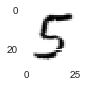

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
print(lbl_dict[int(Y_train[11])])
image = X_train.values[11].reshape([28, 28])
image = image.transpose()
sns.set(rc={'figure.figsize':(2.0, 1.0)})
plt.imshow(image, cmap = mpl.cm.binary)
plt.show()

In [6]:
def rotate(image):
    image = image.reshape([28, 28])
    image = image = image.transpose()
    return image.reshape([28 * 28])
X_train = np.apply_along_axis(rotate,1,X_train)

In [7]:
# data vary from [0 - 255] normalize it to [0 - 1]
X_train = X_train / 255.0

In [ ]:
# import numpy as np
# def split_train_test(data, test_ratio):
#     shuffled_indices = np.random.permutation(len(data))
#     test_set_size = int(len(data) * test_ratio)
#     test_indices = shuffled_indices[:test_set_size] train_indices = shuffled_indices[test_set_size:]
#     return data.iloc[train_indices], data.iloc[test_indices]

In [8]:
# reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.reshape(-1,28,28,1)

In [9]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 47)

a -> 
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


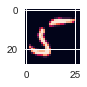

In [32]:
print(cY_train[1]+ ' -> ')
print(Y_train[1])
g = plt.imshow(X_train[1][:,:,0],origin='upper')


In [31]:
# drop 1

# X_train = np.delete(X_train, (1), axis=0) # delete row 1
# Y_train = np.delete(Y_train, (1), axis=0)
# cY_train = np.delete(cY_train, (1), axis=0)

# Todo:  Delete operation is resource intencive
# try to change label(Y) to correct value

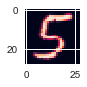

In [12]:
Y_train[1] = 